In [16]:
# !pip install facenet-pytorch

In [335]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import albumentations as A
import os
from pathlib import Path

from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

(224, 224, 3)


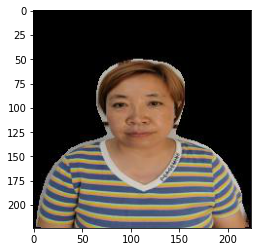

In [505]:
## -- 이미지 불러오기 테스트

img_path = '/opt/ml/input/data/train/images_segmented/000001_female_Asian_45/normal.jpg'
# img_path = '/opt/ml/input/data/train/images/000006_female_Asian_59/incorrect_mask.jpg'
# img_path = '/opt/ml/input/data/train/images/000002_female_Asian_52/mask1.jpg'
# img_path = '/opt/ml/input/data/train/images/000077_male_Asian_59/mask5.jpg'
new_path = Path(img_path)
img = Image.open(new_path)
plt.imshow(img)
print(np.array(img).shape)

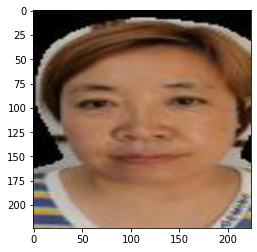

In [506]:
def faceCrop(img, faces, w_ratio, h_ratio, x, y):
    x1, y1, x2, y2 = faces[0][0]
    width = x2 - x1
    height = y2 - y1
    
    new_x = int(x1 - width * w_ratio / 2)
    new_y = int(y1 - height * h_ratio / 2)
    
    if(new_x < 0):
        w_ratio = x1 / width
        new_x = 0
    if(new_y < 0):
        h_ratio = y1 / height
        new_y = 0
    
    new_width = int(width * (1 + w_ratio))
    new_height = int(height * (1 + h_ratio))
    
    if(new_x + new_width > 383):
        new_width = x - new_x
    if(new_y + new_height > 511):
        new_width = y - new_y 
        
    transform = A.Compose([
                        A.Crop(new_x, new_y, new_x+new_width, new_y+new_height),
                        A.Resize(224, 224)
                        ])
    

    img = transform(image=np.array(img))['image']
    return img

detector = MTCNN()
face = detector.detect(img)
plt.imshow(faceCrop(img, face, 0.3, 0.5, 224, 224))

In [481]:
csv_path = '/opt/ml/input/data/train/full_path_three_label.csv'
df = pd.read_csv(csv_path)

In [482]:
train_dir = True
target_dir = 'train' if train_dir else 'eval'
crop_img_dir_path = '/opt/ml/input/data/{}/images_faceCrop'.format(target_dir)
seg_crop_img_dir_path = '/opt/ml/input/data/{}/images_seg_crop'.format(target_dir)
orig_img_dir_path = '/opt/ml/input/data/{}/images'.format(target_dir)

if not os.path.isdir(crop_img_dir_path):
    os.mkdir(crop_img_dir_path)

In [483]:
li = df["mask"].to_list()
normal_idx = []
for i in range(len(li)):
    if li[i] == 2:
        normal_idx.append(i)

In [507]:
count = 0
people_n = int(len(df)/7)
 

for idx in range(0, people_n):
    normal_path = Path(df['path'].iloc[normal_idx[idx]])
    normal_img = Image.open(normal_path)
    normal_face = detector.detect(normal_img)
    
    for j in range(7):
        ori_path = Path(df['path'].iloc[idx*7+j])
        seg_path = Path(str(f_path).replace('images', 'images_segmented'))
        
        ori_img = Image.open(ori_path)
        seg_img = Image.open(seg_path)
        face = detector.detect(ori_img)
        face = detector.detect(ori_img)
        if(face[1][0] != None):
            crop_img = Image.fromarray(faceCrop(ori_img, face, 0.3, 0.5, 384, 512))
            seg_crop_img = Image.fromarray(faceCrop(seg_img, face, 0.3, 0.5, 224, 224))
        else:
            crop_img = Image.fromarray(faceCrop(ori_img, normal_face, 0.3, 0.5, 384, 512))
            seg_crop_img = Image.fromarray(faceCrop(seg_crop_img, normal_face, 0.3, 0.5, 224, 224))
            
        crop_new_dir = Path(crop_img_dir_path) / ori_path.parent.name
        seg_crop_new_dir = Path(seg_crop_img_dir_path) / ori_path.parent.name
        if not os.path.isdir(crop_new_dir):
            os.makedirs(crop_new_dir)
        if not os.path.isdir(seg_crop_new_dir):
            os.makedirs(seg_crop_new_dir)
            
        crop_new_path = crop_new_dir / ori_path.name
        seg_crop_new_path = seg_crop_new_dir / ori_path.name
        
        crop_img.save(crop_new_path)
        seg_crop_img.save(seg_crop_new_path)
        
    if(idx % 100 == 0):
        print(idx)